In [2]:
import os
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import plotly #allows interactive plotting
import contextily as ctx # back ground maps
import rasterio
import shapely

In [3]:
cos_dir = os.getcwd()
while os.path.basename(cos_dir) != 'research_cosumnes':
    cos_dir = os.path.dirname(cos_dir)
gwfm_dir = cos_dir+'/GWFlowModel'


# Quick Map of Loggers

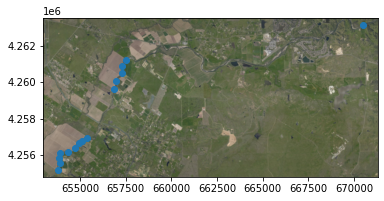

In [4]:
df = pd.read_csv('instream_sensor_latlong.csv')
rm_sp = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude,df.Latitude))
rm_sp.crs = 'epsg:4326'
rm_sp = rm_sp.to_crs('epsg:32610')

fig, ax =plt.subplots(figsize=(6,6))
rm_sp.plot(ax=ax)
# USGS. USImagery, USImageryTopo, USTopo; Esri. WorldImagery, WorldTopoMap
ctx.add_basemap(ax=ax, source=ctx.providers.Esri.WorldImagery, crs='epsg:26910', attribution=False)


In [5]:
dem_dir = os.getcwd()
while os.path.basename(dem_dir) != 'research_cosumnes':
    dem_dir = os.path.dirname(dem_dir)
dem_dir += '/GWFlowModel/DEM_data'



# Get elevation of logger locations

In [7]:
# raster_name = dem_dir+'/USGS_ten_meter_dem/regional_10m.tif'
# raster_name = dem_dir+'/USGS_one_meter_dem/cropped_dem.tif'
# raster_name = dem_dir+'/HECRAS_dem/Terrain.Cos.tif'
raster_name = dem_dir+'/HECRAS_dem/Terrain.Cos.reprojected.tif'

dem_f = rasterio.open(raster_name)
dem = dem_f.read(1)
xmin, xmax = dem_f.bounds[0], dem_f.bounds[2]
ymin, ymax = dem_f.bounds[1], dem_f.bounds[3]
 
rm_t = rm_sp.cx[xmin:xmax, ymin:ymax]
rm_t['Easting'] = rm_t.geometry.x.values
rm_t['Northing'] = rm_t.geometry.y.values

point = rm_t.loc[:,['Easting','Northing']].values

with rasterio.open(raster_name) as src:
    rm_t['z_ft'] = [sample[0] for sample in src.sample(point)]

rm_t['z_m'] = rm_t.loc[:,'z_ft']*0.3048


C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [8]:
cr_xmin, cr_ymin, cr_xmax, cr_ymax = rm_t.buffer(400).total_bounds

(4254817.781617952, 4257372.45118714)

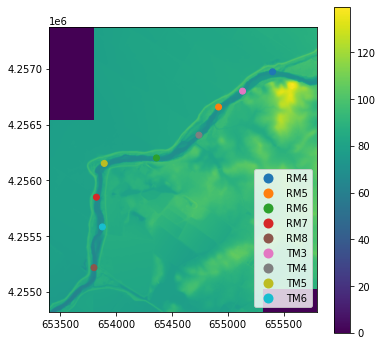

In [9]:
fig,ax=plt.subplots(figsize=(6,6))
rm_t.plot('Sensor', ax=ax, legend=True)

im = ax.imshow(dem, extent = [xmin,xmax,ymin,ymax],vmin=0)
fig.colorbar(im)

plt.xlim(cr_xmin, cr_xmax )
plt.ylim(cr_ymin, cr_ymax )

# Get elevation of "thalweg"
Thalweg here is elevation at shapefile location.

In [10]:
# Rivers and creeks in the larger area encompassing Cosumnes River in both South American and Cosumnes Subbasins
rivers = gpd.read_file(gwfm_dir+"/SFR_data/Sac_valley_rivers/Sac_valley_rivers.shp")
rivers = rivers.to_crs('EPSG:32610')
cr = rivers[rivers.GNIS_Name =='Cosumnes River']
# crop cosumnes river line to teichert
cr = cr.cx[cr_xmin:cr_xmax, cr_ymin:cr_ymax]

# Stream segments, there is a new segment each time two rivers/creeks join one another
cr_line = shapely.geometry.MultiLineString(cr.geometry.values)



In [11]:
import fiona
from shapely.geometry import shape, mapping


geom = shape(cr_line)

# # length of the LineString
length = int(geom.length)
sfr_sp = gpd.GeoDataFrame(pd.DataFrame(np.zeros((length,1)),columns=['id']))
sfr_sp['geometry'] = shapely.geometry.Point(0,0)
# enumerate keeps track of the count in addition to the object being iterated on
for i, distance in enumerate(range(0, length, 1)):
    point = geom.interpolate(distance)
    sfr_sp.loc[i,'geometry'] = point
    sfr_sp.loc[i,'id'] = i

In [22]:
sfr_sp['Easting'] = sfr_sp.geometry.x.values
sfr_sp['Northing'] = sfr_sp.geometry.y.values

point = sfr_sp.loc[:,['Easting','Northing']].values

with rasterio.open(raster_name) as src:
    sfr_sp['z_ft'] = [sample[0] for sample in src.sample(point)]
    
sfr_sp['z_m'] = sfr_sp.loc[:,'z_ft']*0.3048


# Find Cross-section elevations along Teichert


In [110]:
from shapely.ops import linemerge
from shapely.geometry import LineString
from shapely.geometry import Point
import fiona
from shapely.geometry import shape, mapping


## Convert the parallel lines to points 

In [ ]:
# using lengths on the parallel lines won't work because around bends one will become offset
# one option is to pick a point on the line to interpolate and pick one point a little further 
# then do parallel offset to that line and create the transect that way

In [77]:
transects = pd.DataFrame(np.zeros((len(pointup),1)), columns = ['line'])
transects['geometry'] = LineString([(0,0),(0,1)]) #initiate LineString geometry column

geom = linemerge(cr.geometry.values)
# geom = geom.simplify(10)
# how often to interpolate a point
dline = 100
# # length of the LineString
length = int(geom.length)
xs_width = 200
for i, distance in enumerate(range(0, int(length), dline)):
    short_line = LineString([geom.interpolate(distance),geom.interpolate(distance+dline)])
    geom_left = short_line.parallel_offset(xs_width/2,'left', resolution = 32, join_style = 2)
    geom_right = short_line.parallel_offset(xs_width/2,'right', resolution = 32, join_style = 2)
    perp_line = LineString([geom_left.boundary[1], geom_right.boundary[0]])
    transects.loc[i,'geometry'] = perp_line

<AxesSubplot:>

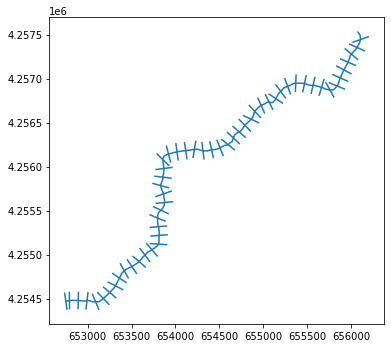

In [91]:
transg = gpd.GeoDataFrame(transects)
transg = transg.drop_duplicates('geometry')
transg['line'] = np.arange(0,len(transg))
# check cross section lines are paralle
fig,ax=plt.subplots(figsize=(6,6))
transg.plot(ax=ax)
cr.plot(ax=ax)

## Sample elevations for each point
Can sample elevation by converting all lines to points then sampling each point or by sampling one line at a time.

In [162]:
# # how often to interpolate a point in a XS
dline = 1

xs_all = gpd.GeoDataFrame(pd.DataFrame(columns=['xs_num','dist_from_right_m','geometry']))


for j in np.arange(0,len(transg)):
    xs = gpd.GeoDataFrame(pd.DataFrame(np.zeros((int(xs_width/dline),2)), columns=['xs_num','dist_from_right_m']))
    xs['geometry'] = Point([(0,0)])
    xs['xs_num'] = j
    
    # pick one geometry at a time
    geom = transg.iloc[j].geometry

    # # # length of the LineString
    length = int(geom.length)
    # create discrete points for each lien
    for i, distance in enumerate(range(0, int(length), dline)):
        point = geom.interpolate(distance)
        xs.loc[i,'geometry'] = point
        xs.loc[i,'dist_from_right_m'] = i
    # append individual cross section to all dataframe
    xs_all = xs_all.append(xs)

<AxesSubplot:>

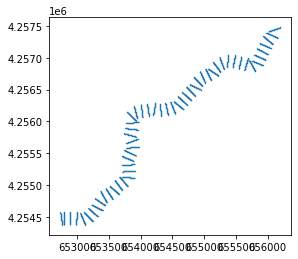

In [138]:
xs_all.plot(markersize=0.01)

In [163]:
xs_all.crs='epsg:32610'
xs_all['Easting'] = xs_all.geometry.x
xs_all['Northing'] = xs_all.geometry.y
point = xs_all.loc[:,['Easting','Northing']].values

with rasterio.open(raster_name) as src:
    xs_all['z_ft'] = [sample[0] for sample in src.sample(point)]

xs_all['z_m'] = xs_all.loc[:,'z_ft']*0.3048



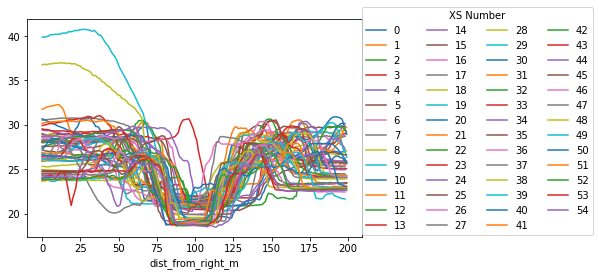

In [193]:
# remove any NA values picked up from DEM raster
xs_all.loc[xs_all['z_ft']==-9999,['z_ft','z_m']] = np.nan
xs_all.index = np.arange(0,len(xs_all))
xs_all.drop(['geometry'],axis=1).to_csv('XS_point_elevations.csv')

# convert to dataframe for easier plotting
xs_all_df = pd.DataFrame(xs_all)
# pivot based on XS number and save only elevation in z_m
xs_all_df = xs_all_df.pivot_table(index='dist_from_right_m',columns='xs_num',values='z_m')
xs_all_df.to_csv('Elevation_by_XS_number_meters.csv')
xs_all_df.plot()
plt.legend(ncol=4, loc=(1,0.01), title='XS Number')


<AxesSubplot:>

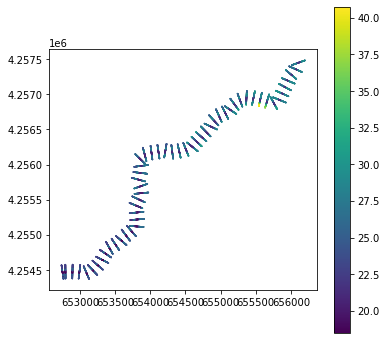

In [135]:
fig,ax=plt.subplots(figsize=(6,6))
xs_all.plot('z_m', markersize=0.2,legend=True,ax=ax)